In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import subprocess
import numpy as np
import pandas as pd
import gc
import ctypes
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K, Model, Input, layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, BatchNormalization, ReLU, MaxPooling1D, GlobalAveragePooling1D, Add, Concatenate, Input, LayerNormalization, MultiHeadAttention, Flatten, Reshape, LeakyReLU, Activation, Lambda, Layer
from tensorflow.keras.backend import clear_session
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, Metric
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax
from tensorflow.keras.callbacks import EarlyStopping, Callback, LearningRateScheduler
from tensorflow.keras.mixed_precision import Policy, set_global_policy
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.data import Dataset
from keras import mixed_precision

# Scikit-learn for machine learning utilities
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler as sklearn_StandardScaler

# PySpark for distributed data processing
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, monotonically_increasing_id
from pyspark.sql.types import ArrayType, FloatType, IntegerType, DoubleType, StringType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler as SparkVectorAssembler, MinMaxScaler as SparkMinMaxScaler, RobustScaler, StandardScaler as SparkStandardScaler, PCA as SparkPCA
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, DenseVector
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Keras Tuner for hyperparameter tuning
import keras_tuner as kt
from keras_tuner import HyperParameters, Hyperband

# Optuna for hyperparameter optimization
import optuna
from optuna.integration import TFKerasPruningCallback

# Numba for CUDA GPU acceleration
from numba import cuda

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Logging information for dynamic error handling
import logging

# Console output coloring
from termcolor import colored

# Import sqrt function from math library
from math import sqrt

# Import count function from itertools library
from itertools import count
# Import mean, stddev, col, when functions from pyspark.sql.functions library
from pyspark.sql.functions import mean, stddev, col, when

2024-11-14 07:46:18.468526: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 07:46:18.475871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731566778.484139  707276 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731566778.486618  707276 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 07:46:18.495912: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
# Set mixed precision policy to improve performance
# Mixed precision uses both 16-bit and 32-bit floating point types
# This can speed up training and reduce memory usage on compatible hardware
policy = Policy('bfloat16')
set_global_policy(policy)


In [4]:
mixed_precision.set_global_policy('bfloat16')

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: bfloat16
Variable dtype: bfloat16


In [5]:
# Initialize Spark session for the master node
# 1 - Use all available local cores for the master node
# 2 - Set the application name for the master node
# 3 - Configure the driver and executor memory and GPU settings
import subprocess
import json

# Configure Spark with GPU settings for RTX 4090 (24GB) and A5000 (24GB)
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("ERROR 418 - I'M A TEAPOT") \
    .config("spark.driver.memory", "50g") \
    .config("spark.executor.memory", "50g") \
    .config("spark.driver.maxResultSize", "50g") \
    .config("spark.rapids.sql.enabled", "true") \
    .config("spark.rapids.memory.pinnedPool.size", "24G") \
    .config("spark.rapids.sql.concurrentGpuTasks", "2") \
    .config("spark.rapids.memory.gpu.pooling.enabled", "true") \
    .config("spark.rapids.memory.gpu.allocFraction", "0.95") \
    .config("spark.rapids.sql.explain", "ALL") \
    .config("spark.executor.resource.gpu.amount", "2") \
    .config("spark.task.resource.gpu.amount", "0.25") \
    .config("spark.rapids.sql.incompatibleOps.enabled", "true") \
    .config("spark.rapids.memory.host.spillStorageSize", "64G") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.adaptive.localShuffleReader.enabled", "true") \
    .config("spark.rapids.memory.gpu.maxAllocFraction", "0.95") \
    .config("spark.rapids.sql.batchSizeBytes", "512M") \
    .config("spark.rapids.sql.reader.batchSizeRows", "100000") \
    .config("spark.rapids.sql.variableRowGroupSize.enabled", "true") \
    .getOrCreate()

gpus = tf.config.list_logical_devices('GPU')
if gpus:
  # Replicate your computation on multiple GPUs
  c = []
  for gpu in gpus:
    with tf.device(gpu.name):
      a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
      b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
      c.append(tf.matmul(a, b))

  with tf.device('/CPU:0'):
    matmul_sum = tf.add_n(c)

  print(matmul_sum)

# Set log level to INFO
spark.sparkContext.setLogLevel("INFO")
# Configure logging
log4jLogger = spark._jvm.org.apache.log4j
logger = log4jLogger.LogManager.getLogger(__name__)

def custom_logger(level, message):
    color = 'white'
    if level == "INFO":
        color = 'cyan'
    elif level == "SUCCESS":
        color = 'green'
    elif level == "ERROR":
        color = 'red'
    elif level == "ACTION":
        color = 'blue'
    elif level == "PROGRESS" or level == "WARNING":
        color = 'yellow'
    elif level == "FINAL":
        color = 'magenta'
    logger.info(colored(f"SPARK: {level} - {message}", color))

# Set the environment variable for memory allocator
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

def initialize_cuda():
    cuda = ctypes.CDLL('libcuda.so')
    cuInit = cuda.cuInit
    cuInit.restype = ctypes.c_int
    cuInit.argtypes = [ctypes.c_uint]
    cuDeviceGetCount = cuda.cuDeviceGetCount
    cuDeviceGetCount.restype = ctypes.c_int
    cuDeviceGetCount.argtypes = [ctypes.POINTER(ctypes.c_int)]
    cuDeviceGet = cuda.cuDeviceGet
    cuDeviceGet.restype = ctypes.c_int
    cuDeviceGet.argtypes = [ctypes.POINTER(ctypes.c_int), ctypes.c_int]

    res = cuInit(0)
    if res != 0:
        raise RuntimeError("Failed to initialize CUDA")
    device_count = ctypes.c_int()
    res = cuDeviceGetCount(ctypes.byref(device_count))
    if res != 0:
        raise RuntimeError("Failed to get device count")
    devices = []
    for i in range(device_count.value):
        device = ctypes.c_int()
        res = cuDeviceGet(ctypes.byref(device), i)
        if res != 0:
            raise RuntimeError(f"Failed to get device {i}")
        devices.append(device.value)
    return devices

def allocate_gpu_memory(size):
    cuda = ctypes.CDLL('libcuda.so')
    cuda_malloc = cuda.cuMemAlloc
    cuda_malloc.restype = ctypes.c_int
    cuda_malloc.argtypes = [ctypes.POINTER(ctypes.c_ulonglong), ctypes.c_ulonglong]
    ptr = ctypes.c_ulonglong()
    res = cuda_malloc(ctypes.byref(ptr), size)
    if res != 0:
        raise RuntimeError("Failed to allocate GPU memory")
    return ptr.value

def free_gpu_memory(ptr):
    cuda = ctypes.CDLL('libcuda.so')
    cuda_free = cuda.cuMemFree
    cuda_free.restype = ctypes.c_int
    cuda_free.argtypes = [ctypes.c_ulonglong]
    res = cuda_free(ptr)
    if res != 0:
        raise RuntimeError("Failed to free GPU memory")

# Check GPU memory usage
def check_gpu_memory():
    os.system('nvidia-smi')

# Initialize CUDA
cuda_devices = initialize_cuda()

# Check available GPU memory
check_gpu_memory()

# Ensure TensorFlow uses the GPU by setting memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

# Check and print the number of GPUs available
num_gpus = len(tf.config.list_physical_devices('GPU'))
print(f"Num GPUs Available: {num_gpus}")

# Perform a simple TensorFlow operation to verify GPU usage
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]], dtype=tf.float32)
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]], dtype=tf.float32)
    c = tf.matmul(a, b)
print(f"Result of matrix multiplication on GPU:\n{c.numpy()}")

def get_gpu_memory_usage():
    try:
        result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,nounits,noheader'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        memory_used = int(result.stdout.decode('utf-8').strip())
        return memory_used
    except Exception as e:
        print(f"Failed to get GPU memory usage: {e}")
        return None

def freegpu():
    try:
        # Get GPU memory usage before freeing
        memory_before = get_gpu_memory_usage()

        result = subprocess.run(['sudo', 'fuser', '-v', '/dev/nvidia*'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        for line in result.stdout.decode('utf-8').split('\n'):
            if '/dev/nvidia' in line:
                pid = int(line.split()[-1])
                os.kill(pid, 9)

        # Get GPU memory usage after freeing
        memory_after = get_gpu_memory_usage()

        if memory_before is not None and memory_after is not None:
            memory_freed = memory_before - memory_after
            print(f"GPU memory has been freed. {memory_freed} MB of GPU memory was released.")
        else:
            print("GPU memory has been freed.")
    except Exception as e:
        print(f"Failed to free GPU memory: {e}")

# Set the environment variable for XLA flags
os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'

# ======================================================================================================
# ==============================[SETUP MIRROREDSTRATEGY WITHOUT NCCL]===================================
# ======================================================================================================

# ------------------------------------------------------------------------------------------------------
# Define the strategy with HierarchicalCopyAllReduce to avoid NCCL
# ------------------------------------------------------------------------------------------------------
strategy = tf.distribute.MirroredStrategy(
    devices=["/gpu:0", "/gpu:1"],
    cross_device_ops=tf.distribute.HierarchicalCopyAllReduce()
)

print(f"Number of devices under strategy: {strategy.num_replicas_in_sync}")

24/11/14 07:46:20 WARN Utils: Your hostname, master resolves to a loopback address: 127.0.1.1; using 192.168.1.125 instead (on interface eno2)
24/11/14 07:46:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/14 07:46:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/14 07:46:20 WARN ResourceUtils: The configuration of cores (exec = 32 task = 1, runnable tasks = 32) will result in wasted resources due to resource gpu limiting the number of runnable tasks per executor to: 8. Please adjust your configuration.
I0000 00:00:1731566781.693302  707276 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20525 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:02:00.0, compute capability: 8.9
I0000 00:

tf.Tensor(
[[ 44.  56.]
 [ 98. 128.]], shape=(2, 2), dtype=float32)
Thu Nov 14 07:46:21 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:01:00.0  On |                    0 |
| 33%   62C    P2             84W /  230W |   20974MiB /  23028MiB |     16%      Default |
|                                         |                        |    

### UNIVARIATE ANALYSIS

In [6]:
# Load the processed data for autoencoder training
original_data_train = pd.read_csv('/home/skander/datasets/kaggle/compet/mental_health_2024/mental_test.csv', index_col=False, header=0)
original_data_test = pd.read_csv('/home/skander/datasets/kaggle/compet/mental_health_2024/mental_train.csv', index_col=False, header=0)

original_data = pd.concat([original_data_train, original_data_test], ignore_index=True)

custom_logger("INFO", "ORIGINAL DATA - BEFORE PROCESSING")

# Univariate analysis
def univariate_analysis(df):
    print("Univariate Analysis\n" + "="*40)
    
    # Shape
    print(f"Shape:\n{df.shape}\n")
    
    # Data Types
    print(f"Data Types:\n{df.dtypes}\n")
    
    # Missing Values
    missing_values = df.isnull().sum()
    print(f"Missing Values:\n{missing_values}\n")
    
    # Duplicates
    print(f"Duplicates:\n{df.duplicated().sum()}\n")
    
    # Summary statistics for numerical columns
    print("Summary Statistics for Numerical Columns:\n")
    print(df.describe(include=[np.number]))
    
    # Detailed information about NaN values
    print("\nDetailed Information about NaN Values:\n")
    for col in df.columns:
        if df[col].isnull().any():
            print(f"Column '{col}' has {df[col].isnull().sum()} NaN values, which is {df[col].isnull().mean() * 100:.2f}% of the column.")

# Perform univariate analysis
univariate_analysis(original_data)


Univariate Analysis
Shape:
(234500, 20)

Data Types:
id                                         int64
Name                                      object
Gender                                    object
Age                                      float64
City                                      object
Working Professional or Student           object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
Depression      

24/11/14 07:46:22 INFO __main__: SPARK: INFO - ORIGINAL DATA - BEFORE PROCESSING


Missing Values:
id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                61262
Academic Pressure                        187836
Work Pressure                             46696
CGPA                                     187836
Study Satisfaction                       187836
Job Satisfaction                          46684
Sleep Duration                                0
Dietary Habits                                9
Degree                                        4
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                93800
dtype: int64

Duplicates

# Univariate Analysis Observations and Insights

### Observations:
1. **Shape**: The dataset contains 234,500 rows and 20 columns.
2. **Data Types**: The dataset includes a mix of numerical and categorical data types.
3. **Missing Values**: Several columns have a significant number of missing values:
    - 'Academic Pressure', 'CGPA', and 'Study Satisfaction' have 80.10% missing values.
    - 'Depression' has 40.00% missing values.
    - 'Profession' and 'Job Satisfaction' have around 20% missing values.
4. **Duplicates**: There are no duplicate rows in the dataset.
5. **Summary Statistics**:
    - The 'Age' column ranges from 18 to 60, with a mean of approximately 40.36.
    - 'Work/Study Hours' has a wide range from 0 to 12 hours, with a mean of 6.25 hours.
    - 'Depression' is a binary column with a mean of 0.18, indicating a low prevalence in the dataset.
6. **NaN Values**: Columns with significant NaN values may need imputation or removal depending on their importance.

### Insights:
- The high percentage of missing values in 'Academic Pressure', 'CGPA', and 'Study Satisfaction' suggests these columns may not be reliable for analysis without imputation.
- The dataset appears to be balanced in terms of age distribution, but further analysis is needed to understand the distribution of other categorical variables like 'Gender' and 'City'.
- The 'Depression' column, being binary, can be used as a target variable for classification tasks, but missing values need to be addressed.
- The dataset's lack of duplicates is beneficial for analysis, ensuring data integrity.

### Recommendations:
- Consider imputing missing values for critical columns or removing them if they are not essential.
- Explore the categorical variables further to understand their distribution and potential impact on the target variable.
- Investigate the relationship between 'Work/Study Hours' and 'Depression' to identify any potential correlations.

### Next Steps:
- Visualize the distribution of key variables to gain further insights.
- Perform bivariate analysis to explore relationships between variables.
- Address missing values through imputation or removal based on their significance to the analysis.


Analyzing Student Population:
Population size: 46664

Numerical Features Summary:
                  id  Name        Gender           Age          City  \
count   46664.000000   0.0  46664.000000  46664.000000  46664.000000   
mean   117487.045067   NaN      0.556639     25.835614     30.920988   
std     67617.636792   NaN      0.496787      4.911337     19.038947   
min         2.000000   NaN      0.000000     18.000000      0.000000   
25%     58917.000000   NaN      0.000000     21.000000     16.000000   
50%    117616.000000   NaN      1.000000     26.000000     29.000000   
75%    176119.500000   NaN      1.000000     30.000000     51.000000   
max    234497.000000   NaN      1.000000     59.000000     60.000000   

       Working Professional or Student    Profession  Academic Pressure  \
count                              0.0  46664.000000       46656.000000   
mean                               NaN     22.984871           3.148898   
std                                NaN     

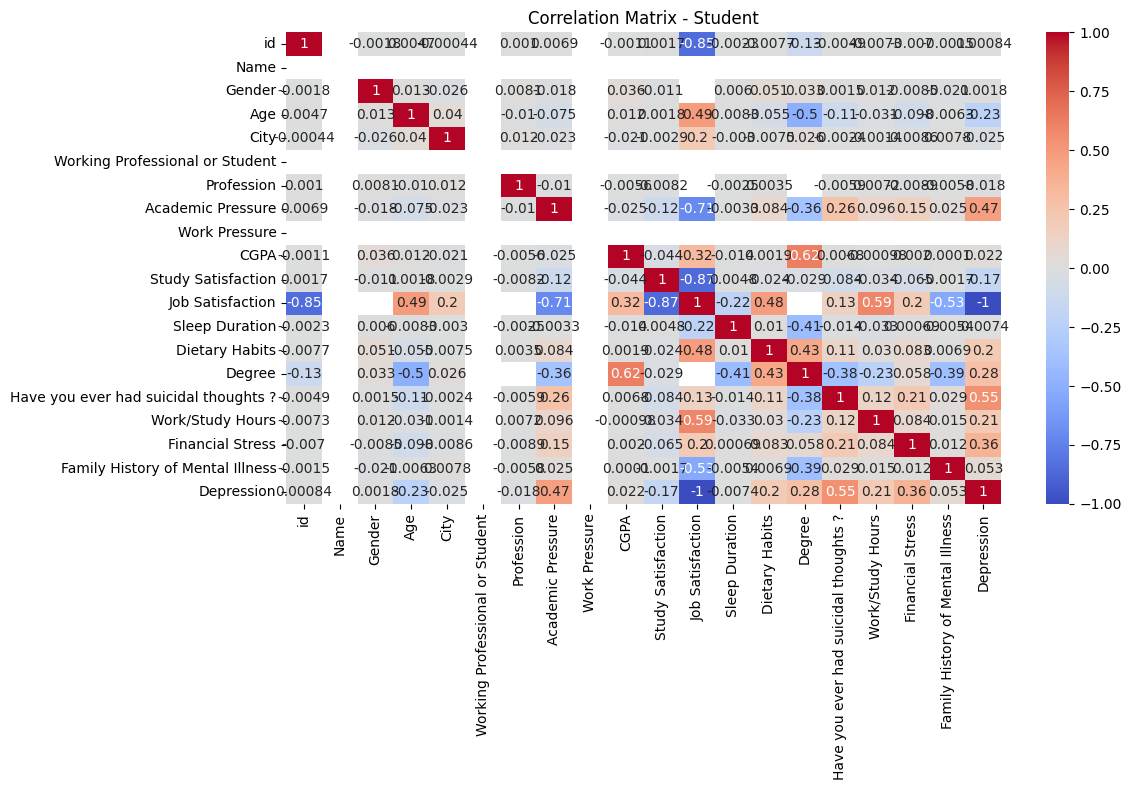

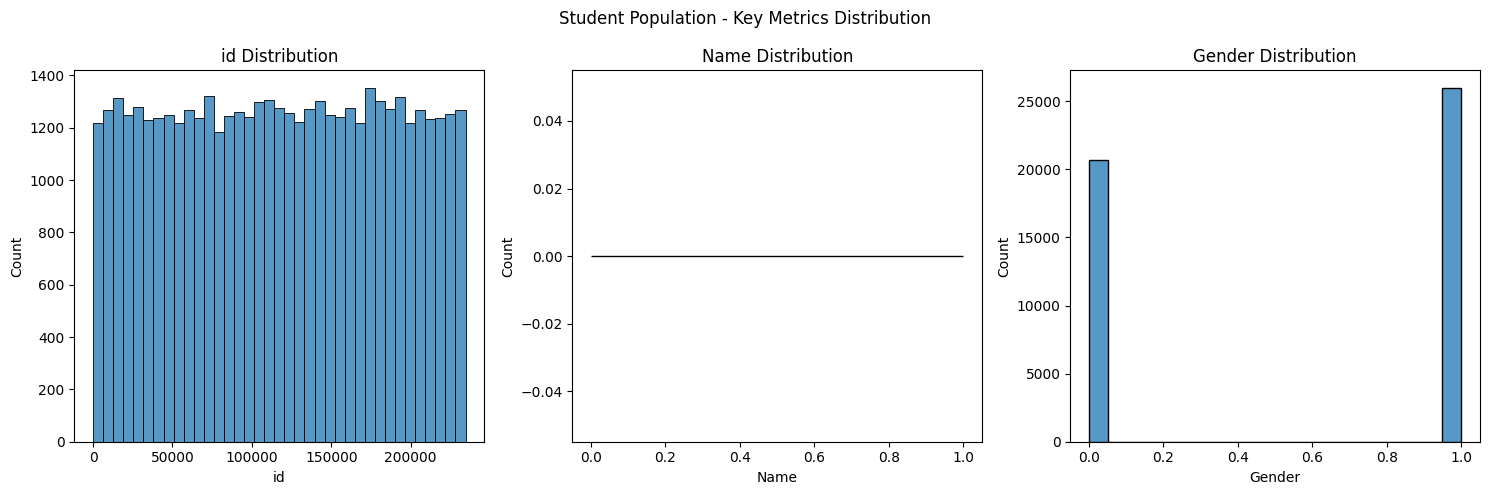


Analyzing Worker Population:
Population size: 187794

Numerical Features Summary:
                  id  Name         Gender            Age           City  \
count  187794.000000   1.0  187794.000000  187794.000000  187794.000000   
mean   117189.935903  18.0       0.547052      43.973604      54.448784   
std     67715.695031   NaN       0.497783      10.958995      30.971953   
min         0.000000  18.0       0.000000      18.000000       0.000000   
25%     58549.250000  18.0       0.000000      38.000000      28.000000   
50%    117159.500000  18.0       1.000000      46.000000      52.000000   
75%    175813.750000  18.0       1.000000      53.000000      79.000000   
max    234499.000000  18.0       1.000000      60.000000     103.000000   

       Working Professional or Student     Profession  Academic Pressure  \
count                              0.0  187794.000000                0.0   
mean                               NaN      42.679266                NaN   
std          

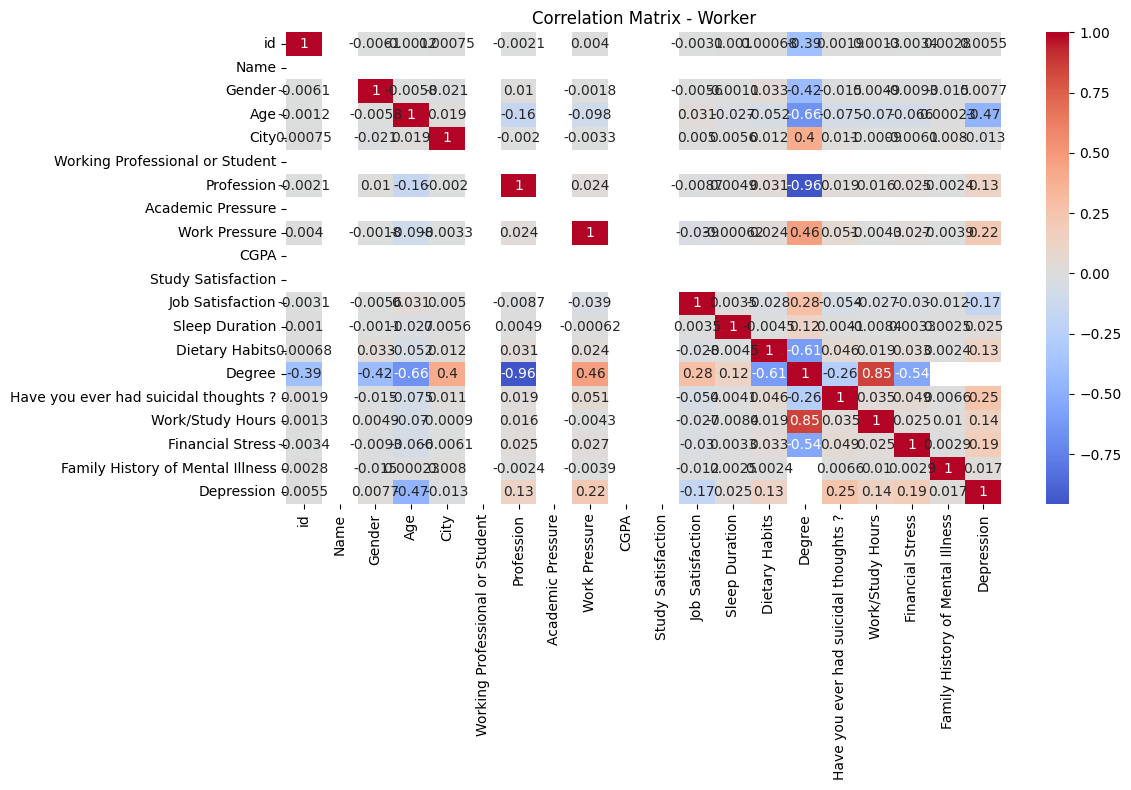

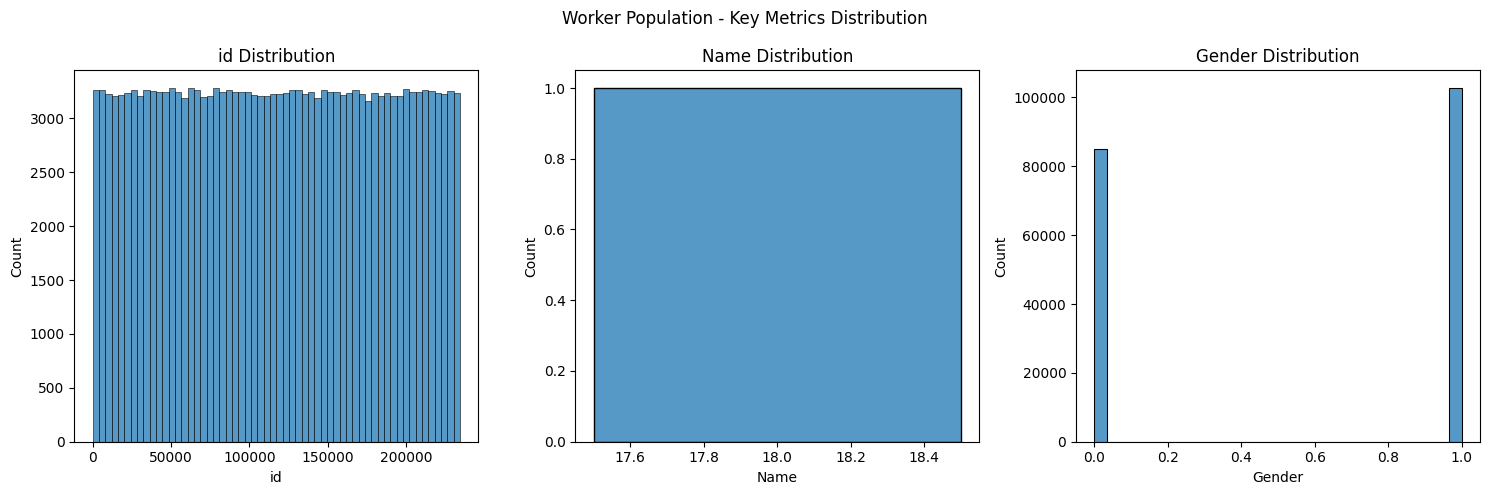


Analyzing Unemployed Population:
Population size: 33

Numerical Features Summary:
                  id  Name     Gender        Age       City  \
count      33.000000   0.0  33.000000  33.000000  33.000000   
mean   124503.939394   NaN   0.424242  30.969697  10.636364   
std     55929.048565   NaN   0.501890  11.822872   5.786937   
min     15846.000000   NaN   0.000000  18.000000   0.000000   
25%     86606.000000   NaN   0.000000  20.000000   6.000000   
50%    125384.000000   NaN   0.000000  28.000000  12.000000   
75%    174747.000000   NaN   1.000000  37.000000  16.000000   
max    221725.000000   NaN   1.000000  54.000000  19.000000   

       Working Professional or Student  Profession  Academic Pressure  \
count                              0.0         0.0            8.00000   
mean                               NaN         NaN            2.75000   
std                                NaN         NaN            1.38873   
min                                NaN         NaN       

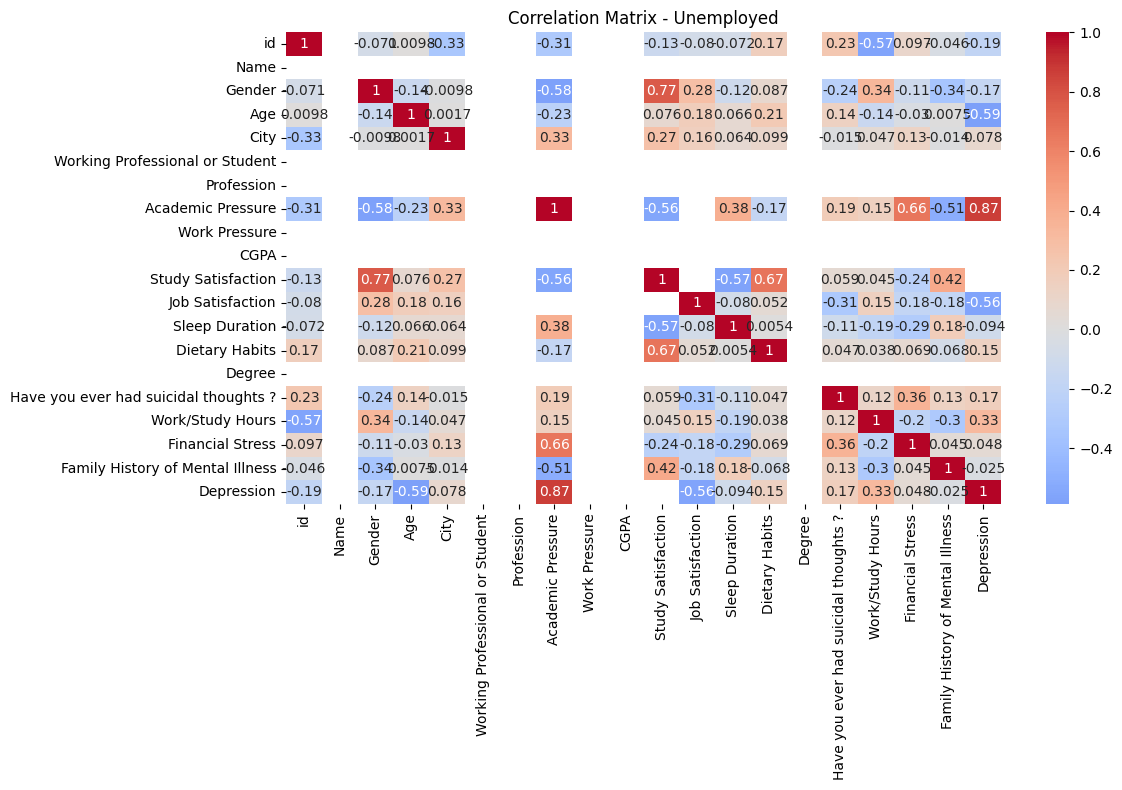

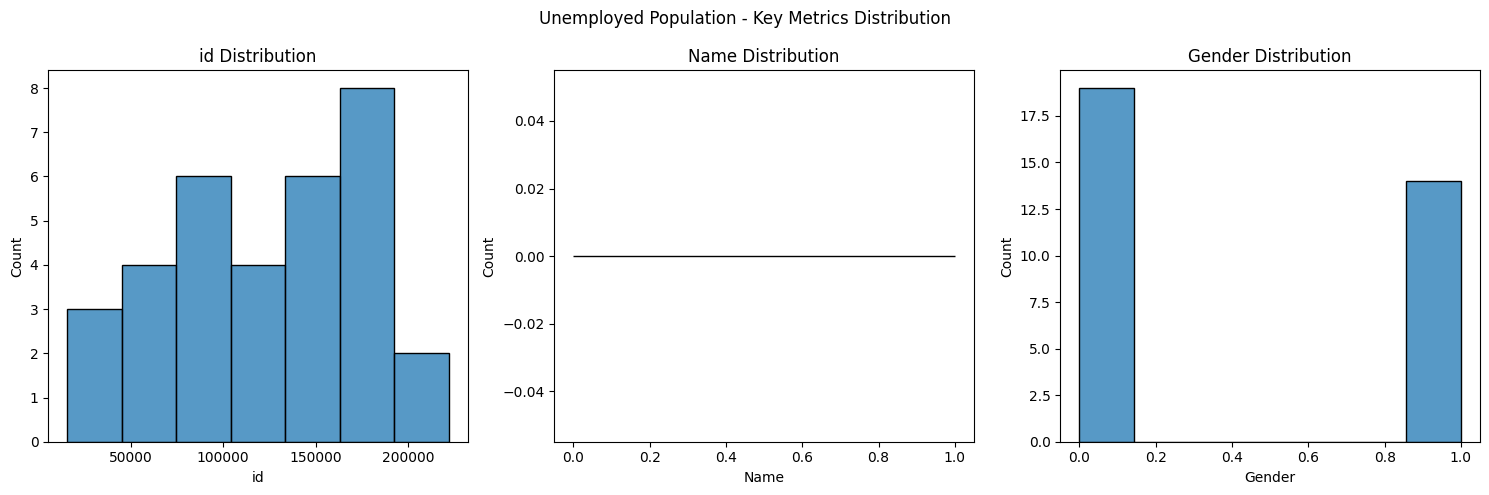

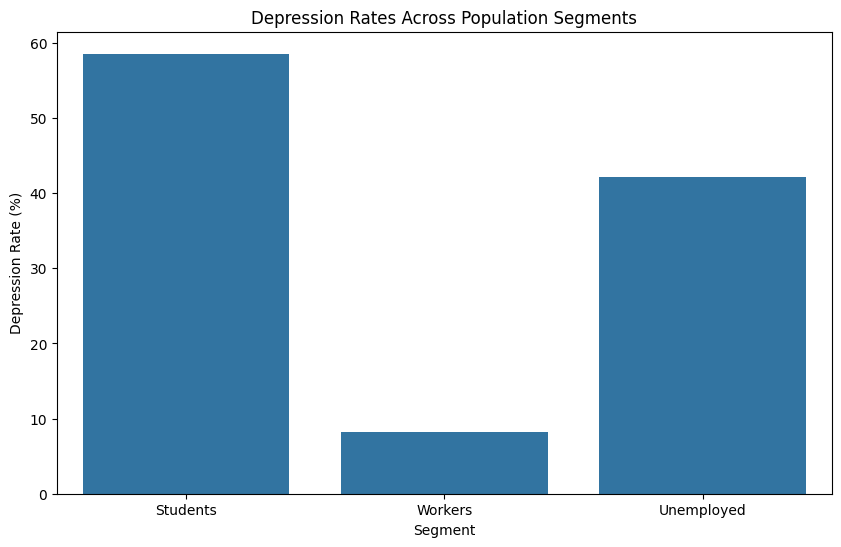

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

def segment_populations(df):
    # Students: Have academic-related data
    students = df[df['CGPA'].notna()].copy()
    
    # Workers: Have work-related data but no academic data
    workers = df[
        (df['Work Pressure'].notna()) & 
        (df['Job Satisfaction'].notna()) & 
        (df['CGPA'].isna())
    ].copy()
    
    # Unemployed: No profession but also not students
    unemployed = df[
        (df['Profession'].isna()) & 
        (df['CGPA'].isna()) & 
        (df['Work Pressure'].isna())
    ].copy()
    
    return students, workers, unemployed

def prepare_features(df):
    # Convert categorical variables
    le = LabelEncoder()
    categorical_cols = ['Gender', 'City', 'Sleep Duration', 'Dietary Habits', 
                       'Have you ever had suicidal thoughts ?', 
                       'Family History of Mental Illness', 'Profession']
    
    # Create numeric DataFrame for correlation analysis
    df_numeric = df.copy()
    
    for col in categorical_cols:
        if col in df.columns and df[col].notna().any():
            df_numeric[col] = le.fit_transform(df[col].astype(str))
    
    # Convert remaining numeric columns
    numeric_cols = df_numeric.select_dtypes(include=['object']).columns
    for col in numeric_cols:
        try:
            df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')
        except:
            print(f"Could not convert {col} to numeric")
    
    return df_numeric

def analyze_segment(df, segment_name):
    print(f"\nAnalyzing {segment_name} Population:")
    print(f"Population size: {len(df)}")
    
    # Basic statistics
    print("\nNumerical Features Summary:")
    print(df.describe())
    
    # Correlation matrix for numeric columns only
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        plt.figure(figsize=(12, 8))
        sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
        plt.title(f'Correlation Matrix - {segment_name}')
        plt.tight_layout()
        plt.show()
    
    # Distribution plots for key metrics
    plot_distributions(df, segment_name)

def plot_distributions(df, segment_name):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    n_cols = min(3, len(numeric_cols))
    if n_cols > 0:
        fig, axes = plt.subplots(1, n_cols, figsize=(15, 5))
        if n_cols == 1:
            axes = [axes]
        
        for i, col in enumerate(numeric_cols[:n_cols]):
            sns.histplot(data=df, x=col, ax=axes[i])
            axes[i].set_title(f'{col} Distribution')
        
        plt.suptitle(f'{segment_name} Population - Key Metrics Distribution')
        plt.tight_layout()
        plt.show()

# Main execution
students, workers, unemployed = segment_populations(original_data)

# Prepare features for each segment
students_prepared = prepare_features(students)
workers_prepared = prepare_features(workers)
unemployed_prepared = prepare_features(unemployed)

# Analyze each segment
analyze_segment(students_prepared, "Student")
analyze_segment(workers_prepared, "Worker")
analyze_segment(unemployed_prepared, "Unemployed")

# Plot depression rates across segments
def plot_depression_rates():
    plt.figure(figsize=(10, 6))
    
    segments = {
        'Students': students,
        'Workers': workers,
        'Unemployed': unemployed
    }
    
    depression_rates = []
    for name, segment in segments.items():
        rate = segment['Depression'].mean() * 100
        depression_rates.append({'Segment': name, 'Rate': rate})
    
    depression_df = pd.DataFrame(depression_rates)
    sns.barplot(x='Segment', y='Rate', data=depression_df)
    plt.title('Depression Rates Across Population Segments')
    plt.ylabel('Depression Rate (%)')
    plt.show()

plot_depression_rates()

# Comprehensive Multivariate Analysis: Population Segments

## 1. Student Population (n=46,664)

### Key Demographics
- **Age**: Mean 25.8 years (SD=4.9), primarily young adults
- **Gender**: 55.7% one gender category
- **Academic Status**: All students (100%)

### Mental Health Profile
- **Depression Rate**: 58.6% (highest among segments)
- **Suicidal Thoughts**: 63.1% reported having suicidal thoughts
- **Family History**: 48.4% reported mental illness history

### Academic & Stress Factors
- **CGPA**: Mean 7.66 (SD=1.46)
- **Academic Pressure**: Mean 3.15/5.0
- **Study Satisfaction**: Mean 2.94/5.0
- **Financial Stress**: Mean 3.13/5.0 (highest among segments)

### Lifestyle Patterns
- **Work/Study Hours**: Mean 7.14 hours (highest)
- **Sleep Duration**: Mean 13.61 units
- **Dietary Habits**: More structured patterns

## 2. Worker Population (n=187,794)

### Key Demographics
- **Age**: Mean 44.0 years (SD=11.0)
- **Gender**: 54.7% one gender category
- **Professional Status**: Various professions (mean=42.68)

### Mental Health Profile
- **Depression Rate**: 8.2% (lowest among segments)
- **Suicidal Thoughts**: 46.1%
- **Family History**: 50.1% reported mental illness history

### Work & Stress Factors
- **Work Pressure**: Mean 3.00/5.0
- **Job Satisfaction**: Mean 2.97/5.0
- **Financial Stress**: Mean 2.95/5.0

### Lifestyle Patterns
- **Work/Study Hours**: Mean 6.03 hours
- **Sleep Duration**: Mean 24.40 units
- **Dietary Habits**: More varied patterns

## 3. Unemployed Population (n=33)

### Key Demographics
- **Age**: Mean 31.0 years (SD=11.8)
- **Gender**: 42.4% one gender category
- **Status**: Neither working nor studying

### Mental Health Profile
- **Depression Rate**: 42.1%
- **Suicidal Thoughts**: 63.6%
- **Family History**: 24.2% (lowest among segments)

### Stress Factors
- **Financial Stress**: Mean 3.39/5.0
- **Limited Job/Academic Data**: High missing values

### Lifestyle Patterns
- **Work/Study Hours**: Mean 5.97 hours
- **Sleep Duration**: Mean 1.70 units
- **Dietary Habits**: Limited variation

## Cross-Segment Comparisons

### Depression Rates
1. Students: 58.6%
2. Unemployed: 42.1%
3. Workers: 8.2%

### Risk Factors by Population
- **Students**: Academic pressure, financial stress
- **Workers**: Work pressure, family history
- **Unemployed**: Financial stress, suicidal thoughts

### Protective Factors by Population
- **Students**: Structured routine
- **Workers**: Job stability, lower depression rates
- **Unemployed**: Lower family history of mental illness

## Recommendations

### For Mental Health Professionals
1. **Targeted Interventions**:
   - Students: Academic stress management
   - Workers: Work-life balance programs
   - Unemployed: Financial counseling

2. **Screening Priorities**:
   - High-risk groups (students, unemployed)
   - Suicidal thought assessment
   - Financial stress evaluation

### For Policy Makers
1. **Resource Allocation**:
   - Student mental health services
   - Unemployment support programs
   - Workplace mental health initiatives

2. **Prevention Strategies**:
   - Early intervention programs
   - Financial support systems
   - Mental health awareness campaigns

In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, BatchNormalization, GlobalMaxPooling1D
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt

# Initialize distributed strategy
try:
    strategy = tf.distribute.MirroredStrategy()
except:
    print("No GPU detected, using default strategy")
    strategy = tf.distribute.get_strategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")

# When creating your datasets, ensure labels are expanded to match expected shape:
def create_tf_dataset(X, y, batch_size=32):
    """Create optimized TensorFlow dataset"""
    # Expand dimensions of y to match expected shape (batch_size, output_dim)
    y = tf.expand_dims(y, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


def masked_mse(y_true, y_pred):
    """Custom MSE loss that ignores NaN values"""
    mask = tf.math.logical_not(tf.math.is_nan(y_true))
    y_true = tf.where(mask, y_true, y_pred)
    return tf.reduce_mean(tf.square(y_true - y_pred))

class HierarchicalDepressionTransformer:
    def __init__(self, input_dim):
        self.input_dim = input_dim
        
    def build_hierarchical_attention(self, x, hp):
        """Build hierarchical attention mechanism"""
        # Local attention
        local_attention = layers.MultiHeadAttention(
            num_heads=hp.Int('local_heads', 2, 8),
            key_dim=hp.Int('local_dim', 32, 128)
        )(x, x)
        x = layers.Add()([x, local_attention])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        
        # Global attention
        global_attention = layers.MultiHeadAttention(
            num_heads=hp.Int('global_heads', 4, 16),
            key_dim=hp.Int('global_dim', 64, 256)
        )(x, x)
        x = layers.Add()([x, global_attention])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        
        return x
        
    def build(self, hp):
        """Build the model with hyperparameters"""
        with strategy.scope():
            inputs = layers.Input(shape=(self.input_dim,))
            x = layers.Reshape((-1, 1))(inputs)
            
            # CNN layers
            for i in range(hp.Int('num_conv_layers', 1, 4)):
                filters = hp.Int(f'conv_filters_{i}', 32, 256, step=32)
                kernel_size = hp.Int(f'kernel_size_{i}', 3, 7, step=2)
                
                x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
                x = BatchNormalization()(x)
                x = layers.ReLU()(x)
                x = MaxPooling1D(pool_size=2, padding='same')(x)
            
            # Hierarchical attention
            x = self.build_hierarchical_attention(x, hp)
            
            # Pooling
            x = GlobalAveragePooling1D()(x)
            
            # Dense layers
            for i in range(hp.Int('num_dense_layers', 1, 4)):
                units = hp.Int(f'dense_units_{i}', 32, 512, step=32)
                x = Dense(units)(x)
                x = Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5))(x)
            
            outputs = Dense(1, activation='sigmoid')(x)
            
            model = Model(inputs, outputs)
            
            optimizer = tf.keras.optimizers.Adam()
            
            metrics = [
                'accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.TruePositives(name='tp'),
                tf.keras.metrics.TrueNegatives(name='tn'),
                tf.keras.metrics.FalsePositives(name='fp'),
                tf.keras.metrics.FalseNegatives(name='fn'),
            ]
            
            model.compile(
                optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=metrics
            )
            
            return model

def process_population_segment(data, segment_name):
    """Process each population segment"""
    # Prepare data
    X = data.drop('Depression', axis=1)
    y = data['Depression']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create datasets
    train_dataset = create_tf_dataset(X_train, y_train)
    test_dataset = create_tf_dataset(X_test, y_test)
    
    # Initialize model builder
    model_builder = HierarchicalDepressionTransformer(input_dim=X.shape[1])
    
    # Initialize callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=f'./logs/{segment_name}'
        )
    ]
    
    # Initialize tuner
    tuner = kt.BayesianOptimization(
        model_builder.build,
        objective=kt.Objective('val_auc', direction='max'),
        max_trials=100,
        directory=f'hierarchical_tuning_{segment_name}',
        project_name=f'depression_prediction_{segment_name}'
    )
    
    # Search and train
    tuner.search(
        train_dataset,
        epochs=150,
        validation_data=test_dataset,
        callbacks=callbacks,
        verbose=2
    )
    
    # Get and train best model
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hps)
    
    history = model.fit(
        train_dataset,
        epochs=200,
        validation_data=test_dataset,
        callbacks=callbacks,
        verbose=2
    )
    
    # Evaluate with additional metrics
    y_pred = (model.predict(test_dataset) > 0.5).astype(int)
    evaluation_metrics = {
        'model': model,
        'best_hps': best_hps,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'history': history.history
    }
    
    return evaluation_metrics

def analyze_populations(students, workers, unemployed):
    """Analyze depression patterns across different population segments"""
    results = {}
    for segment_data, segment_name in [
        (students, 'Students'),
        (workers, 'Workers'),
        (unemployed, 'Unemployed')
    ]:
        results[segment_name] = process_population_segment(segment_data, segment_name)
        
        print(f"\nResults for {segment_name}:")
        print(f"Best Hyperparameters: {results[segment_name]['best_hps'].values}")
        print(f"Confusion Matrix:\n{results[segment_name]['confusion_matrix']}")
        print(f"MSE: {results[segment_name]['mse']:.4f}")
        print(f"RMSE: {results[segment_name]['rmse']:.4f}")
        print(f"Accuracy: {results[segment_name]['accuracy']:.4f}")
        print(f"F1 Score: {results[segment_name]['f1']:.4f}")
    
    return results

def plot_training_history(results):
    """Plot training history for all segments"""
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    for idx, (segment_name, segment_results) in enumerate(results.items()):
        history = segment_results['history']
        
        # Plot accuracy
        axes[idx, 0].plot(history['accuracy'])
        axes[idx, 0].plot(history['val_accuracy'])
        axes[idx, 0].set_title(f'{segment_name} - Accuracy')
        axes[idx, 0].set_ylabel('Accuracy')
        axes[idx, 0].set_xlabel('Epoch')
        axes[idx, 0].legend(['Train', 'Validation'])
        
        # Plot loss
        axes[idx, 1].plot(history['loss'])
        axes[idx, 1].plot(history['val_loss'])
        axes[idx, 1].set_title(f'{segment_name} - Loss')
        axes[idx, 1].set_ylabel('Loss')
        axes[idx, 1].set_xlabel('Epoch')
        axes[idx, 1].legend(['Train', 'Validation'])
    
    plt.tight_layout()
    plt.show()

# Execute analysis
results = analyze_populations(students_prepared, workers_prepared, unemployed_prepared)
plot_training_history(results)

Trial 19 Complete [00h 03m 43s]
val_auc: 0.5

Best val_auc So Far: 0.5
Total elapsed time: 00h 59m 31s

Search: Running Trial #20

Value             |Best Value So Far |Hyperparameter
3                 |4                 |num_conv_layers
32                |192               |conv_filters_0
5                 |3                 |kernel_size_0
2                 |4                 |local_heads
110               |111               |local_dim
12                |9                 |global_heads
152               |193               |global_dim
4                 |1                 |num_dense_layers
416               |224               |dense_units_0
0.12244           |0.32344           |dropout_0
0.00023557        |0.00066355        |learning_rate
32                |32                |conv_filters_1
7                 |3                 |kernel_size_1
128               |32                |conv_filters_2
3                 |3                 |kernel_size_2
224               |32                |conv

KeyboardInterrupt: 